<a href="https://colab.research.google.com/github/TejazerX/BinBuddy/blob/main/BinBuddy_real_time_object_detection_and_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/TejazerX/BinBuddy)

# Real time waste detection and classification using YOLOv11

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

Here we are using YOLOv11 for fastest results.

# Setup

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

## Install YOLO11 via Ultralytics

In [ ]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

## Clone the Repository

In [ ]:
!git clone https://github.com/TejazerX/BinBuddy
!cd BinBuddy

In [ ]:
!pip install inference

In [ ]:
from ultralytics import YOLO

model = YOLO('/content/BinBuddy/runs/detect/train/weights/best.pt')

# Mock the project and dataset values since we're not using Roboflow download
class DummyProject:
    id = "binbuddy-zknvw/binbuddy-trash-examples"

class DummyDataset:
    version = 2

class DummyModel:
    def predict(self, img):
        print("Running prediction on image:", img)

project = DummyProject()
dataset = DummyDataset()

# Construct the model_id manually
model_id = project.id.split("/")[1] + "/" + str(dataset.version)

print("Model ID:", model_id)  # Output: binbuddy-trash-examples/2



# Use your own YOLOv11 model here instead of Roboflow's hosted API
model = DummyModel()

# Visualizing the trained model

**NOTE:** The results of the trained model is saved in `{HOME}/BinBuddy/runs/detect/train/`. Let's examine them.

In [ ]:
!ls {HOME}/BinBuddy/runs/detect/train/

args.yaml					   train_batch0.jpg
events.out.tfevents.1728808341.0d14cabbea16.923.0  train_batch1.jpg
labels_correlogram.jpg				   train_batch2.jpg
labels.jpg					   weights
results.csv


In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/BinBuddy/runs/detect/train/confusion_matrix.png', width=600)

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/BinBuddy/runs/detect/train/results.png', width=600)

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/BinBuddy/runs/detect/train/val_batch0_pred.jpg', width=600)

# Validating the fine-tuned model

In [ ]:
!yolo task=detect mode=val model=/content/BinBuddy/runs/detect/train/weights/best.pt data=f'{HOME]/BinBuddy/datasets/BinBuddy-trash-examples-2'/data.yaml

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs
Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/cfg/__init__.py", line 981, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 633, in val
    validator(model=self.model)
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/_contextlib.py", line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/validator.py", line 179, in __call__
    self.data = check_det_dataset(self.args.data)
                ^^^^^^^^^^^^^^^^^^^^

# Inference with custom model

In [ ]:
!yolo task=detect mode=predict model="/content/BinBuddy/runs/detect/train/weights/best.pt" conf=0.25 source='/content/BinBuddy/datasets/BinBuddy-trash-examples-2/test/images' save=True

**NOTE:** Let's take a look at few results.

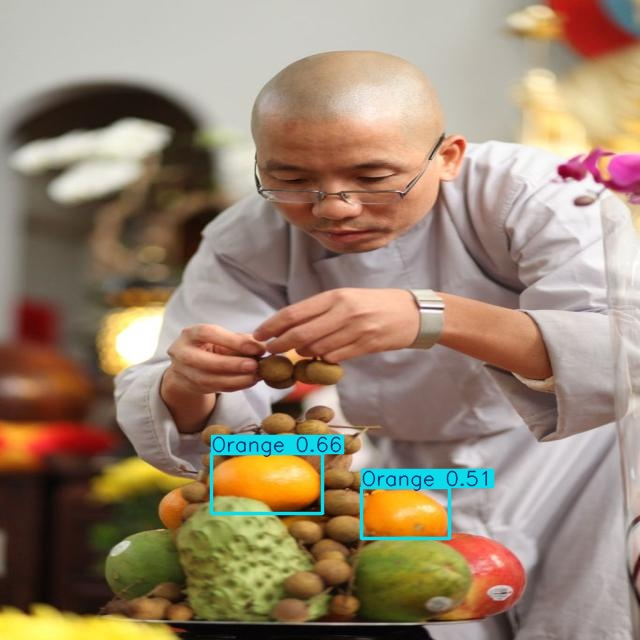

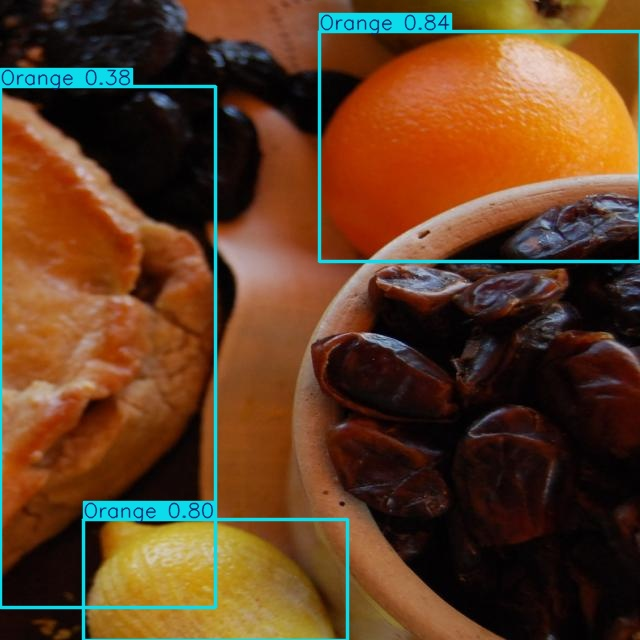

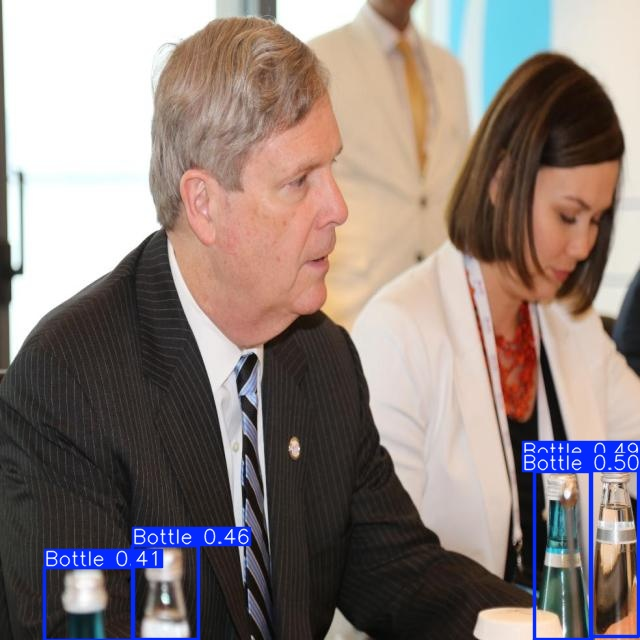

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

# Run the model real time via Webcam stream


In [ ]:
import os, random, cv2
import supervision as sv
import IPython.display as display
from ultralytics import YOLO

# Load model
model_path = "/content/BinBuddy/runs/detect/train/weights/best.pt"
model = YOLO(model_path)

# Set paths
test_set_loc = "/content/BinBuddy/datasets/BinBuddy-trash-examples-2/test/images"
img_list = [f for f in os.listdir(test_set_loc) if f.endswith((".jpg", ".png", ".jpeg"))]

# Annotators
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# Run on up to 4 images
for img_name in random.sample(img_list, min(4, len(img_list))):
    print("Running inference on", img_name)

    image_path = os.path.join(test_set_loc, img_name)
    image = cv2.imread(image_path)

    # Run inference
    results = model(image, conf=0.4)[0]
    detections = sv.Detections.from_ultralytics(results)

    # Annotate
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display
    _, buffer = cv2.imencode('.jpg', annotated_image)
    display.display(display.Image(data=buffer))


In [ ]:
from base64 import b64decode, b64encode
from google.colab.output import eval_js
from IPython.display import display, Javascript
from PIL import Image
from ultralytics import YOLO
from ultralytics.engine.results import Results
import io
import numpy as np

MODEL_NAMES = ['yolov11n.pt', 'yolov11s.pt', 'yolov11m.pt', 'yolov11l.pt', 'yolov11x.pt']
PRE_TRAINED_MODEL = YOLO("/content/BinBuddy/runs/detect/train/weights/best.pt")
IMG_SHAPE = [640, 480]
IMG_QUALITY = 0.8

In [ ]:
def start_stream():
    js = Javascript(f'''
    const IMG_SHAPE = {IMG_SHAPE};
    const IMG_QUALITY = {IMG_QUALITY};
    ''' + '''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
        stream.getVideoTracks()[0].stop();
        video.remove();
        div.remove();
        video = null;
        div = null;
        stream = null;
        imgElement = null;
        captureCanvas = null;
        labelElement = null;
    }

    function onAnimationFrame() {
        if (!shutdown) {
            window.requestAnimationFrame(onAnimationFrame);
        }
        if (pendingResolve) {
            var result = "";
            if (!shutdown) {
                captureCanvas.getContext('2d').drawImage(video, 0, 0, IMG_SHAPE[0], IMG_SHAPE[1]);
                result = captureCanvas.toDataURL('image/jpeg', IMG_QUALITY)
            }
            var lp = pendingResolve;
            pendingResolve = null;
            lp(result);
        }
    }

    async function createDom() {
        if (div !== null) {
            return stream;
        }

        div = document.createElement('div');
        div.style.border = '2px solid black';
        div.style.padding = '3px';
        div.style.width = '100%';
        div.style.maxWidth = '600px';
        document.body.appendChild(div);

        const modelOut = document.createElement('div');
        modelOut.innerHTML = "<span>Status: </span>";
        labelElement = document.createElement('span');
        labelElement.innerText = 'No data';
        labelElement.style.fontWeight = 'bold';
        modelOut.appendChild(labelElement);
        div.appendChild(modelOut);

        video = document.createElement('video');
        video.style.display = 'block';
        video.width = div.clientWidth - 6;
        video.setAttribute('playsinline', '');
        video.onclick = () => { shutdown = true; };
        stream = await navigator.mediaDevices.getUserMedia(
            {video: { facingMode: "environment"}});
        div.appendChild(video);

        imgElement = document.createElement('img');
        imgElement.style.position = 'absolute';
        imgElement.style.zIndex = 1;
        imgElement.onclick = () => { shutdown = true; };
        div.appendChild(imgElement);

        const instruction = document.createElement('div');
        instruction.innerHTML =
            '<span style="color: red; font-weight: bold;">' +
            'When finished, click here or on the video to stop this demo</span>';
        div.appendChild(instruction);
        instruction.onclick = () => { shutdown = true; };

        video.srcObject = stream;
        await video.play();

        captureCanvas = document.createElement('canvas');
        captureCanvas.width = IMG_SHAPE[0]; //video.videoWidth;
        captureCanvas.height = IMG_SHAPE[1]; //video.videoHeight;
        window.requestAnimationFrame(onAnimationFrame);

        return stream;
    }
    async function takePhoto(label, imgData) {
        if (shutdown) {
            removeDom();
            shutdown = false;
            return '';
        }

        var preCreate = Date.now();
        stream = await createDom();

        var preShow = Date.now();
        if (label != "") {
            labelElement.innerHTML = label;
        }

        if (imgData != "") {
            var videoRect = video.getClientRects()[0];
            imgElement.style.top = videoRect.top + "px";
            imgElement.style.left = videoRect.left + "px";
            imgElement.style.width = videoRect.width + "px";
            imgElement.style.height = videoRect.height + "px";
            imgElement.src = imgData;
        }

        var preCapture = Date.now();
        var result = await new Promise((resolve, reject) => pendingResolve = resolve);
        shutdown = false;

        return {
            'create': preShow - preCreate,
            'show': preCapture - preShow,
            'capture': Date.now() - preCapture,
            'img': result,
        };
    }
    ''')
    display(js)

def take_photo(label, img_data):
    data = eval_js(f'takePhoto("{label}", "{img_data}")')
    return data

In [ ]:
def js_response_to_image(js_response) -> Image.Image:
    _, b64_str = js_response['img'].split(',')
    jpeg_bytes = b64decode(b64_str)
    image = Image.open(io.BytesIO(jpeg_bytes))
    return image

def turn_non_black_pixels_visible(rgba_compatible_array: np.ndarray) -> np.ndarray:
    rgba_compatible_array[:, :, 3] = (rgba_compatible_array.max(axis=2) > 0).astype(int) * 255
    return rgba_compatible_array

def black_transparent_rgba_canvas(w, h) -> np.ndarray:
    return np.zeros([w, h, 4], dtype=np.uint8)
def turn_non_black_pixels_visible(rgba_compatible_array: np.ndarray) -> np.ndarray:
    if rgba_compatible_array.shape[2] == 3:
        # Add an alpha channel
        alpha_channel = np.ones((rgba_compatible_array.shape[0], rgba_compatible_array.shape[1], 1), dtype=np.uint8) * 255
        rgba_compatible_array = np.concatenate((rgba_compatible_array, alpha_channel), axis=2)

    rgba_compatible_array[:, :, 3] = (rgba_compatible_array.max(axis=2) > 0).astype(np.uint8) * 255
    return rgba_compatible_array
def draw_annotations_on_image(detection_result: Results) -> Image.Image:
    # Plot directly on a copy of the original image
    annotated_image = detection_result.plot()
    return Image.fromarray(annotated_image)

In [ ]:
start_stream()
img_data = ''
while True:
    js_response = take_photo('Capturing...', img_data)
    if not js_response:
        break
    captured_img = js_response_to_image(js_response)
    for detection_result in PRE_TRAINED_MODEL(source=np.array(captured_img), verbose=False):
        annotations_img = draw_annotations_on_image(detection_result)
        with io.BytesIO() as buffer:
            annotations_img.save(buffer, format='png')
            img_as_base64_str = str(b64encode(buffer.getvalue()), 'utf-8')
            img_data = f'data:image/png;base64,{img_as_base64_str}'

<IPython.core.display.Javascript object>